In [12]:
# Cell 1: Imports and Data Loading
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1. Data Curation: Load Malaria Dataset from TensorFlow Datasets
# This satisfies the requirement for a "Public Dataset"
print("Downloading data...")
dataset, info = tfds.load('malaria', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:]'])
train_raw, test_raw = dataset[0], dataset[1]

# Define Constants
IMG_SIZE = 128
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# 2. Preprocessing (Resizing & Normalization)
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply preprocessing
train_ds = train_raw.map(preprocess).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Data loaded. Classes: {info.features['label'].names}")
# Label 0: Parasitized, Label 1: Uninfected (Note: In this dataset, usually 0=Parasitized, 1=Uninfected or vice versa. We will verify).

Data loaded. Classes: ['parasitized', 'uninfected']


Sample Images (0=Parasitized, 1=Uninfected):


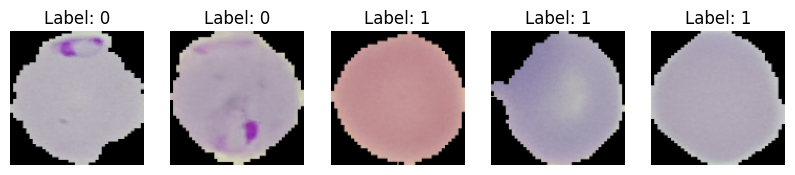

In [13]:
# Cell 2: EDA - Visualize Samples
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(dataset.unbatch().take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {int(label)}")
        plt.axis("off")
    plt.show()

print("Sample Images (0=Parasitized, 1=Uninfected):")
show_samples(train_ds)

In [14]:
# Cell 3: Baseline Model (Simple CNN)
# Requirement: "Train a simple baseline" + SAVE THIS FOR APP

from tensorflow.keras import layers, models, callbacks

def build_baseline():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        # 1st Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # 2nd Conv Block
        # We give this layer a NAME so we can find it easily for Grad-CAM later
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='last_conv'),
        layers.MaxPooling2D((2, 2)),

        # Classification Head
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid') # Binary classification
    ])
    return model

baseline_model = build_baseline()
baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Early Stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Training Baseline Model...")
history_baseline = baseline_model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[early_stop])

# --- SAVE THE CNN MODEL ---
baseline_model.save('cnn_model.h5')
print("✅ Baseline CNN model saved as 'cnn_model.h5'")

Training Baseline Model...
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.6541 - loss: 0.6315 - precision_2: 0.6521 - recall_2: 0.6851 - val_accuracy: 0.9298 - val_loss: 0.2378 - val_precision_2: 0.9159 - val_recall_2: 0.9451
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9199 - loss: 0.2317 - precision_2: 0.9251 - recall_2: 0.9151 - val_accuracy: 0.9267 - val_loss: 0.2028 - val_precision_2: 0.9409 - val_recall_2: 0.9092
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9321 - loss: 0.1858 - precision_2: 0.9459 - recall_2: 0.9181 - val_accuracy: 0.9327 - val_loss: 0.1965 - val_precision_2: 0.9371 - val_recall_2: 0.9264
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9470 - loss: 0.1540 - precision_2: 0.9508 - recall_2: 0.9441 - val_accuracy: 0.9389 - val_loss: 0.2049 - val_precision_2: 0.9414 - val_recall_2: 0.9348
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9534 - loss: 0.1371 - pre

✅ Baseline CNN model saved as 'cnn_model.h5'


In [15]:
# Cell 4: Advanced Model (Functional API Fix)
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, callbacks

def build_advanced_model():
    # 1. Setup Base Model
    base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    # 2. Build Model using Functional API (Fixes the loading error)
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # We explicitly pass inputs through the base_model
    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    return model, base_model

adv_model, base_model = build_advanced_model()
adv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

print("Training Advanced Model (Frozen Base)...")
history_adv = adv_model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=[early_stop])

# Fine-Tuning
print("Fine-tuning Advanced Model...")
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

adv_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])

history_finetune = adv_model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=[early_stop])

# Save the fixed model
adv_model.save('malaria_model.h5')
print("✅ Model saved successfully.")

Training Advanced Model (Frozen Base)...
Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 58s 79ms/step - AUC: 0.8991 - accuracy: 0.8209 - loss: 0.3934 - val_AUC: 0.9761 - val_accuracy: 0.9287 - val_loss: 0.1998
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - AUC: 0.9728 - accuracy: 0.9198 - loss: 0.2084 - val_AUC: 0.9794 - val_accuracy: 0.9314 - val_loss: 0.1848
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - AUC: 0.9748 - accuracy: 0.9267 - loss: 0.1971 - val_AUC: 0.9798 - val_accuracy: 0.9329 - val_loss: 0.1820
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - AUC: 0.9767 - accuracy: 0.9282 - loss: 0.1890 - val_AUC: 0.9809 - val_accuracy: 0.9338 - val_loss: 0.1780
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - AUC: 0.9757 - accuracy: 0.9304 - loss: 0.1893 - val_AUC: 0.9805 - val_accuracy: 0.9329 - val_loss: 0.1819
Fine-tuning Advanced Model...
Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 69s 95ms/step - AUC: 0.9808 - accuracy: 0.9396 - loss: 0.1670 - val_AUC: 0.9873 - val

✅ Model saved successfully.



Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.97      0.94      0.96      2780
  Uninfected       0.94      0.98      0.96      2732

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



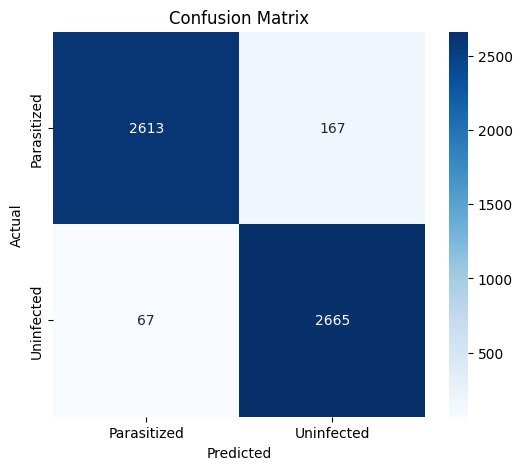

In [16]:
# Cell 5: Evaluation & Metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get Predictions
y_true = []
y_pred = []

for img, label in test_ds:
    y_true.extend(label.numpy())
    preds = adv_model.predict(img, verbose=0)
    y_pred.extend(np.round(preds).flatten())

# Metrics (F1-Score, Precision, Recall)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Generating Heatmap...


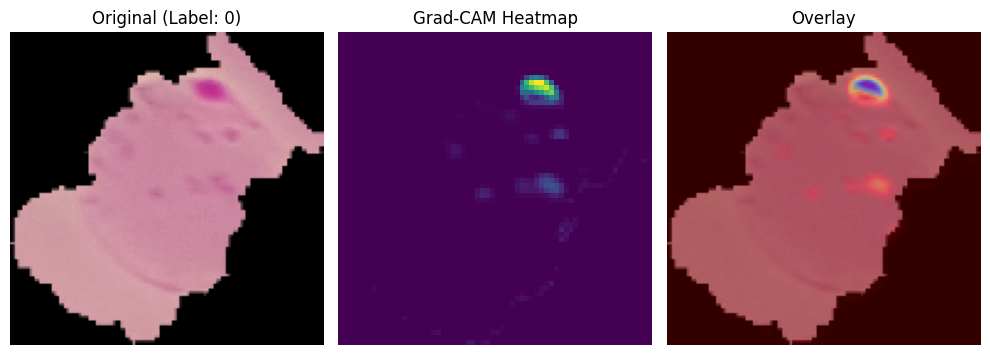

In [19]:
# Cell 6: Grad-CAM Implementation (Fixed for Keras 3 / Colab)
# Requirement: "Visualize why the model made a decision"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Fixed Grad-CAM function that rebuilds the graph to avoid
    'AttributeError: The layer has never been called' in Keras 3.
    """

    # 1. Create a dummy input tensor with the same shape as your images
    # Note: We use the shape from the img_array provided (batch_size, 128, 128, 3)
    input_shape = img_array.shape[1:] # Returns (128, 128, 3)
    inputs = tf.keras.Input(shape=input_shape)

    # 2. Re-trace the model graph using the *existing* trained layers
    # This bypasses the "never been called" error by calling them explicitly now.
    x = inputs
    last_conv_output = None

    for layer in model.layers:
        x = layer(x)
        # Check if this is the layer we want to watch
        if layer.name == last_conv_layer_name:
            last_conv_output = x

    # Final output of the model (prediction)
    model_output = x

    # 3. Create the Grad-CAM model
    # Now we have a clear path from 'inputs' to 'last_conv_output' and 'model_output'
    grad_model = tf.keras.models.Model(inputs=inputs, outputs=[last_conv_output, model_output])

    # 4. Compute Gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # Determine which class we are explaining
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Calculate gradient of the predicted class w.r.t. the feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Pool the gradients (average over the height/width)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the feature map by the pooled gradients (importance)
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)

    return heatmap.numpy()

# --- Visualization Logic ---

# 1. Get a sample image
for img, label in test_ds.take(1):
    sample_img = img[0]
    sample_label = label[0]
    break

# 2. Prepare image
img_array = tf.expand_dims(sample_img, axis=0)

# 3. Generate Heatmap
# We use the 'last_conv' name we defined in Cell 3
print("Generating Heatmap...")
heatmap = make_gradcam_heatmap(img_array, baseline_model, 'last_conv')

# 4. Plotting
plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title(f"Original (Label: {int(sample_label)})")
plt.axis('off')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis('off')

ax3 = plt.subplot(1, 3, 3)
# Overlay
heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
sample_img_uint8 = np.uint8(255 * sample_img)
superimposed_img = cv2.addWeighted(sample_img_uint8, 0.6, heatmap_resized, 0.4, 0)

plt.imshow(superimposed_img)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()